In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/ml_tools_proj

/content/drive/MyDrive/ml_tools_proj


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")
import scipy as sp
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

In [4]:
# read in data and replace nans
data = pd.read_csv('risk_factors_cervical_cancer.csv').\
    replace('?', np.nan)

In [5]:
# impute, default is mean
my_imputer = SimpleImputer()
data_final = pd.DataFrame(my_imputer.fit_transform(data))
data_final.columns= data.columns


In [6]:
# all the target variables, i only use Biopsy
targets = ['Hinselmann', 'Schiller','Citology','Biopsy']

In [7]:
# split data
X = data_final.loc[:, ~data_final.columns.isin(targets)]
y = data_final['Biopsy']

In [8]:
# fit RF
rf = RandomForestClassifier(n_estimators = 500)
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [9]:
def uniform_sample(df, feature, frac_to_plot, seednum = None):
  '''
  #' Uniformly sample across quantiles of x_j
  #' to ensure not to leave out portions of the
  #' dist'n of x.
  #' @param df : Covariate matrix.
  #' @param feature : Target covariate bin.
  #' @param frac_to_plot : Fraction of data set to plot.
  #' @param seed_num : Random seed for reproducibility.
  #' @return Uniformly sampled dataframe with N * frac_to_plot observations.
  #' @examples
  #' uniform_sample(X, 'Age', .33, 420)
  '''
  # get number of rows to sample
  N = df.shape[0] * frac_to_plot

  # get amount for each quantile (sometimes uneven)
  quantile = [N // 4 + (1 if x < N % 4 else 0)  for x in range (4)]

  # create labels and bins for quantiles
  labels, bins = ['q1', 'q2', 'q3', 'q4'], [0, .25, .5, .75, 1.]

  # create col to get quantiles of x_j to not leave out portions of the dist'n of x
  df['quantile'] = pd.qcut(X[feature], q = bins, labels = labels)

  # uniformly sample quantiles
  out = pd.concat([df[df['quantile'].eq(label)].sample(int(quantile[i])) for i, label in enumerate(labels)]).\
      drop(columns = ['quantile'])
  
  return out



In [10]:
def ice_plot(plot_data, feature):

  '''
  #' Generates ICE data
  #' @param plot_data : ICE data to plot
  #' @param feature : Target covariate to plot.
  #' @return ICE plot
  #' @examples
  #' ice_plot(X, 'Age')
  '''

  # set fig size
  plt.figure(figsize=(12,10)) 

  # set lines to all black
  palette = sns.color_palette(['black'], len(plot_data['Obs'].unique()))

  # plot ICE
  sns.lineplot(data=plot_data, x= feature, y="Predicted Probability", hue='Obs', palette=palette, legend=False)
  plt.title('{} ICE Plot'.format(feature), fontsize=18)
  plt.xlabel(feature, fontsize=18)
  plt.ylabel('Predicted Probability', fontsize=16)
  plt.show()

In [11]:
def ice(X, clf, feature, frac_to_plot = 1, seednum = None):

  '''
  #' Generates ICE data
  #' @param X : Covariate matrix.
  #' @param clf : ML classifier.
  #' @param feature : Target covariate to plot.
  #' @param frac_to_plot : Fraction of data set to plot.
  #' @param seed_num : Random seed for reproducibility.
  #' @return ICE data (dataframe) with N observations.
  #' @examples
  #' ice_plot(X, rf, 'Age', frac_to_plot = .33 , seednum = 420)
  '''

  # initialize dict
  d = {feature: np.array([]), 'Predicted Probability': np.array([]), 'Obs': np.array([])}

  # uniformly sample
  X = uniform_sample(X, feature, frac_to_plot, seednum)
  for index, row in X.iterrows():
  
    # make temp df for each instance
    temp_df = X.copy()

    # make copy for fixed feature
    feat = X[feature].copy()

    # alter rows of DF except fixed feature
    temp_df.loc[:, :] = temp_df.loc[index, :].values
    temp_df[feature] = feat
    # get predictions
    preds = rf.predict_proba(temp_df)[:,1]
    d[feature] = np.append(feat.array, d[feature])
    d['Predicted Probability'] = np.append(preds, d['Predicted Probability'])
    d['Obs'] = np.append(np.repeat(index, X.shape[0]), d['Obs'])

  df = pd.DataFrame(d) 

  return ice_plot(df, feature)
  



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


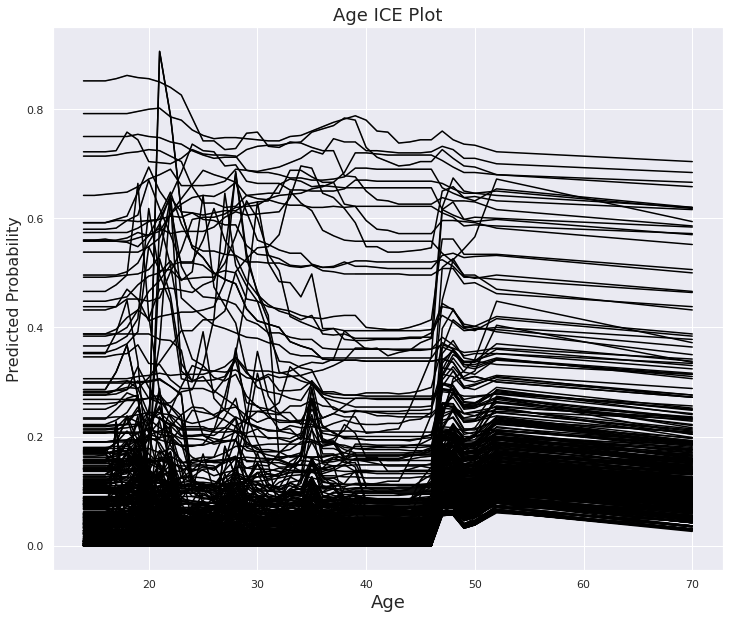

In [12]:
%timeit
seednum = 420
ice(X = X, clf = rf, feature = 'Age', frac_to_plot = .50, seednum = seednum)